In [46]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

Ref - https://www.kaggle.com/loveall/appliances-energy-prediction

In [47]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

We will use the in-built **MPG** dataset in Seaborn library.

In [48]:
# import data
df = sns.load_dataset('mpg')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


# EDA

In [49]:
# drop duplicates, if any
df.drop_duplicates(inplace=True)
print(df.shape)

(398, 9)


In [50]:
# summary statistics
df.describe(include='all')

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398,398
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,305
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,usa,ford pinto
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249,6
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,NaN,NaN
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,NaN,NaN
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,NaN,NaN
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,NaN,NaN
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,NaN,NaN
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,NaN,NaN


In [51]:
# check for NULLs
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [52]:
df[df.horsepower.isnull()]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
32,25.0,4,98.0,NaN,2046,19.0,71,usa,ford pinto
126,21.0,6,200.0,NaN,2875,17.0,74,usa,ford maverick
330,40.9,4,85.0,NaN,1835,17.3,80,europe,renault lecar deluxe
336,23.6,4,140.0,NaN,2905,14.3,80,usa,ford mustang cobra
354,34.5,4,100.0,NaN,2320,15.8,81,europe,renault 18i
374,23.0,4,151.0,NaN,3035,20.5,82,usa,amc concord dl


In [53]:
df[df.horsepower.isnull()].name

32               ford pinto
126           ford maverick
330    renault lecar deluxe
336      ford mustang cobra
354             renault 18i
374          amc concord dl
Name: name, dtype: object

In [54]:
# getting horsepower of cars where NA as it can be easily googled
df.horsepower[(df.name == 'ford pinto') & df.horsepower.isnull()] = 75
df.horsepower[(df.name == 'ford maverick') & df.horsepower.isnull()] = 75
df.horsepower[(df.name == 'ford mustang cobra') & df.horsepower.isnull()] = 88
df.horsepower[(df.name == 'renault 18i') & df.horsepower.isnull()] = 60
df.horsepower[(df.name == 'amc concord dl') & df.horsepower.isnull()] = 82
df.horsepower[(df.name == 'renault lecar deluxe') & df.horsepower.isnull()] = 50

In [55]:
# RE-check for NULLs
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

In [56]:
# drop name
df.drop('name', axis = 1, inplace=True)

- All but 2 variables are numeric and there are no NULL values, so we can move ahead. 
- We will not do any feature transformation here either just to demonstrate how regularization makes better generalized predictions.

In [57]:
# converting categorical vars into object
df['model_year'] = df['model_year'].astype('object')
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year       object
origin           object
dtype: object

## Check for correlation and outliers

Here, we will simply check the presence of outliers and correlation since we will see how much of those factors is overcome by regularization.

In [58]:
# function to get number of outliers 
def outliers(x):
    import numpy as np
    import pandas as pd
    
    # we will use values > 1.5(IQR) as outliers and equate them to the 90th/10th percentile values 
    
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    iqr_upper_bound = 1.5*iqr + np.percentile(x, 75)
    iqr_lower_bound = np.percentile(x, 25) - 1.5*iqr
    
    return iqr_upper_bound, iqr_lower_bound

print("Number of outliers - ")
print("="*20)

for e in df.columns[:-2]:
    print(e, "-", df[e][df[e] > outliers(df[e])[0]].count() + df[e][df[e] < outliers(df[e])[1]].count())

Number of outliers - 
mpg - 1
cylinders - 0
displacement - 0
horsepower - 10
weight - 0
acceleration - 9


<AxesSubplot:>

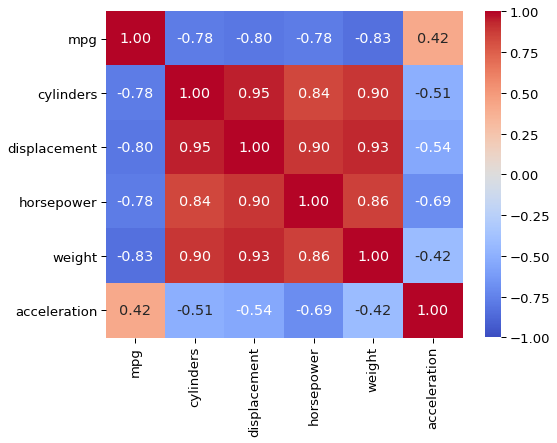

In [59]:
# correlation plot
plt.figure(figsize=(8,6))
sns.set_context('paper', font_scale=1.5)

df_corr = df.corr()

sns.heatmap(df_corr, annot=True, cmap = 'coolwarm', vmin = -1, vmax = 1, fmt = '.2f')

# Model Building

## Train Test Splits

In [60]:
# train test split
from sklearn.model_selection import train_test_split

# get dummies for categorical variables
df = pd.get_dummies(df, drop_first=False)

# df.drop(['model_year', 'origin'], axis = 1, inplace=True)

X = df.drop('mpg', axis = 1)
y = df['mpg']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # add constants to X_train, X_test
# import statsmodels.api as sm

# X_train, X_test = sm.add_constant(X_train), sm.add_constant(X_test)

print('X_train =', X_train.shape)
print('X_test =', X_test.shape)
print('y_train =', y_train.shape)
print('y_test =', y_test.shape)

X_train = (318, 21)
X_test = (80, 21)
y_train = (318,)
y_test = (80,)


In [61]:
df.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model_year_70', 'model_year_71', 'model_year_72',
       'model_year_73', 'model_year_74', 'model_year_75', 'model_year_76',
       'model_year_77', 'model_year_78', 'model_year_79', 'model_year_80',
       'model_year_81', 'model_year_82', 'origin_europe', 'origin_japan',
       'origin_usa'],
      dtype='object')

## Linear Regression

In [62]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
linear_regressor_cv = cross_validate(estimator = linear_regressor, X = X_train, y = y_train,
                                     scoring=['neg_mean_squared_error', 'r2'], cv=5,
                                     return_train_score = True)
# mean_mse=np.mean(mse)
# print(mean_mse)
linear_regressor_cv

{'fit_time': array([0.00599504, 0.00599623, 0.00299692, 0.00600386, 0.00401258]),
 'score_time': array([0.00299788, 0.00199866, 0.0019989 , 0.00399113, 0.00198317]),
 'test_neg_mean_squared_error': array([ -9.55243402,  -8.46179781, -11.95026333, -10.64035714,
        -11.02142178]),
 'train_neg_mean_squared_error': array([-9.09028382, -9.28713504, -8.62586302, -8.80629074, -8.99095648]),
 'test_r2': array([0.85060745, 0.83550606, 0.83067871, 0.84073125, 0.80646625]),
 'train_r2': array([0.8530289 , 0.8576228 , 0.85782757, 0.85657496, 0.85971978])}

In [63]:
linear_regressor_cv_results = pd.DataFrame(linear_regressor_cv)
# linear_regressor_cv_results = linear_regressor_cv_results.loc[:, ['params', 'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 'mean_test_r2', 'std_test_r2']]
# linear_regressor_cv_results.iloc[linear_regressor.best_index_, :]
linear_regressor_cv_results

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,0.005995,0.002998,-9.552434,-9.090284,0.850607,0.853029
1,0.005996,0.001999,-8.461798,-9.287135,0.835506,0.857623
2,0.002997,0.001999,-11.950263,-8.625863,0.830679,0.857828
3,0.006004,0.003991,-10.640357,-8.806291,0.840731,0.856575
4,0.004013,0.001983,-11.021422,-8.990956,0.806466,0.859720


In [64]:
# score
linear_regressor_cv_results.test_neg_mean_squared_error.mean()

-10.325254817907972

In [65]:
# metrics
y_pred = linear_regressor.predict(X_test)

In [66]:
# explained variance
from sklearn.metrics import explained_variance_score
explained_variance_score(y_test, y_pred)

0.8409414534323778

In [67]:
# r2_score
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8406429223064463

In [68]:
# MSE, RMSE
from sklearn.metrics import mean_squared_error
[mean_squared_error(y_test, y_pred), np.sqrt(mean_squared_error(y_test, y_pred))]

[8.568063353974836, 2.927125442131723]

## Regularization Techniques

In all of the regularization techniques, we will make use of `GridSearchCV` function from the `sklearn.model_selection` module to chose the best value of ***Alpha*** for regularization. 

In [69]:
from sklearn.model_selection import GridSearchCV

### 1. Lasso Regression - L1 Regularization

In [70]:
from sklearn.linear_model import Lasso

lasso = Lasso()
cv_parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor = GridSearchCV(estimator = lasso,
                               param_grid=cv_parameters,
                               cv = 5,
                               scoring = ['neg_mean_squared_error', 'r2'],
                               refit = 'neg_mean_squared_error',
                               return_train_score = 'True')
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             refit='neg_mean_squared_error', return_train_score='True',
             scoring=['neg_mean_squared_error', 'r2'])

In [71]:
lasso_regressor.best_score_

-10.298817647511822

In [72]:
lasso_cv_results = pd.DataFrame(lasso_regressor.cv_results_)
lasso_cv_results = lasso_cv_results.iloc[:, [5, 11, 12, 19, 20, 26, 27, 34, 35]]
# lasso_cv_results.iloc[lasso_regressor.best_index_, :]  # for best index
# list(enumerate(lasso_cv_results.columns))
lasso_cv_results.sort_values(by = 'mean_test_neg_mean_squared_error', ascending = False)

,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,mean_test_r2,std_test_r2,mean_train_r2,std_train_r2
4,{'alpha': 0.01},-10.298818,1.203727,-8.983044,0.227944,0.833353,0.013232,0.856588,0.002215
3,{'alpha': 0.001},-10.320733,1.206826,-8.960338,0.228133,0.832884,0.014577,0.856951,0.002210
2,{'alpha': 1e-08},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
1,{'alpha': 1e-10},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
0,{'alpha': 1e-15},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
5,{'alpha': 1},-19.249548,2.133160,-18.660886,0.550501,0.689039,0.010507,0.702141,0.002640
6,{'alpha': 5},-19.355822,1.943487,-18.721203,0.552665,0.686850,0.013478,0.701178,0.002623
7,{'alpha': 10},-19.611907,1.742994,-18.910003,0.559434,0.682045,0.019438,0.698166,0.002573
8,{'alpha': 20},-20.016648,1.611141,-19.421622,0.473604,0.674741,0.026917,0.689933,0.004718
12,{'alpha': 45},-20.058467,1.430870,-19.754898,0.351037,0.673913,0.026134,0.684540,0.006338


### 2. Ridge Regression - L2 Regularization 

In [73]:
from sklearn.linear_model import Ridge

ridge = Ridge()
cv_parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor = GridSearchCV(estimator = ridge,
                               param_grid=cv_parameters,
                               cv = 5,
                               scoring = ['neg_mean_squared_error', 'r2'],
                               refit = 'neg_mean_squared_error',
                               return_train_score = 'True')
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             refit='neg_mean_squared_error', return_train_score='True',
             scoring=['neg_mean_squared_error', 'r2'])

In [74]:
ridge_regressor.best_score_

-10.311579222158336

In [75]:
ridge_cv_results = pd.DataFrame(ridge_regressor.cv_results_)
ridge_cv_results = ridge_cv_results.iloc[:, [5, 11, 12, 19, 20, 26, 27, 34, 35]]
ridge_cv_results.sort_values(by = 'mean_test_neg_mean_squared_error', ascending = False)

,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,mean_test_r2,std_test_r2,mean_train_r2,std_train_r2
5,{'alpha': 1},-10.311579,1.188781,-8.997841,0.227491,0.833080,0.013757,0.856352,0.002217
4,{'alpha': 0.01},-10.324647,1.207556,-8.960110,0.228133,0.832808,0.014722,0.856955,0.002210
3,{'alpha': 0.001},-10.325194,1.207806,-8.960106,0.228133,0.832799,0.014732,0.856955,0.002210
2,{'alpha': 1e-08},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
1,{'alpha': 1e-10},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
0,{'alpha': 1e-15},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
6,{'alpha': 5},-10.748886,1.219759,-9.534904,0.222334,0.826193,0.011669,0.847772,0.002255
7,{'alpha': 10},-11.562892,1.326397,-10.395192,0.225373,0.813162,0.010949,0.834032,0.002323
8,{'alpha': 20},-12.975287,1.505755,-11.853305,0.256120,0.790437,0.010691,0.810753,0.002617
9,{'alpha': 30},-13.992610,1.624592,-12.905215,0.290738,0.774032,0.010622,0.793961,0.002892


### 3. Elastic Net Regression - L1 + L2 Regularization 

In [76]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet()
cv_parameters = {'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
elastic_net_regressor = GridSearchCV(estimator = elastic_net,
                               param_grid=cv_parameters,
                               cv = 5,
                               scoring = ['neg_mean_squared_error', 'r2'],
                               refit = 'neg_mean_squared_error',
                               return_train_score = 'True')
elastic_net_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             refit='neg_mean_squared_error', return_train_score='True',
             scoring=['neg_mean_squared_error', 'r2'])

In [77]:
elastic_net_regressor.best_score_

-10.31409424026328

In [78]:
elastic_net_cv_results = pd.DataFrame(elastic_net_regressor.cv_results_)
elastic_net_cv_results = elastic_net_cv_results.iloc[:, [5, 11, 12, 19, 20, 26, 27, 34, 35]]
elastic_net_cv_results.sort_values(by = 'mean_test_neg_mean_squared_error', ascending = False)

,params,mean_test_neg_mean_squared_error,std_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_train_neg_mean_squared_error,mean_test_r2,std_test_r2,mean_train_r2,std_train_r2
3,{'alpha': 0.001},-10.314094,1.203238,-8.961214,0.228115,0.832990,0.014535,0.856937,0.002210
4,{'alpha': 0.01},-10.318062,1.180566,-9.053588,0.227097,0.833024,0.013005,0.855461,0.002230
2,{'alpha': 1e-08},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
1,{'alpha': 1e-10},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
0,{'alpha': 1e-15},-10.325255,1.207834,-8.960106,0.228133,0.832798,0.014733,0.856955,0.002210
5,{'alpha': 1},-19.238840,2.156398,-18.652332,0.551440,0.689262,0.010353,0.702279,0.002549
6,{'alpha': 5},-19.279019,2.056187,-18.675318,0.550807,0.688381,0.011487,0.701910,0.002638
7,{'alpha': 10},-19.357039,1.937242,-18.725360,0.551982,0.686811,0.013657,0.701112,0.002630
8,{'alpha': 20},-19.614181,1.738789,-18.919355,0.556708,0.681990,0.019624,0.698015,0.002606
9,{'alpha': 30},-19.916798,1.641253,-19.198035,0.534225,0.676522,0.025332,0.693553,0.002678


In [81]:
# summary
print("Negative Mean Squared Error scores for test datasets in Cross Validation - ")
print("Linear Regression =", format(linear_regressor_cv_results.test_neg_mean_squared_error.mean(), '.3f'))
print("Lasso (L1) Regression =", format(lasso_regressor.best_score_, '.3f'))
print("Ridge (L2) Regression =", format(ridge_regressor.best_score_, '.3f'))
print("Elastic Net (L1 + L2) Regression =", format(elastic_net_regressor.best_score_, '.3f'))

Negative Mean Squared Error scores for test datasets in Cross Validation - 
Linear Regression = -10.325
Lasso (L1) Regression = -10.299
Ridge (L2) Regression = -10.312
Elastic Net (L1 + L2) Regression = -10.314


## Why was OLS not significantly outperformed by Regularization?

- What we saw above is that while scores did improve in case of Regularization, the improvement was extremely insignificant.
- The reason for this is, as mentioned in documentation, that the regularization techniques come handy when OLS overfits our data or we have little data to work with (which also results in overfitting) - 
    > **OLS is ideal when the underlying relationship is Linear and we have `n >> p` *(where `n` is the number of samples and `p` is the number of features)*.**  
    > But if `n` is not much larger than `p` or `p > n` (unfeasible for OLS), there can be a lot of variability in the fit which can result in either overfitting and very poor predictive ability.
- This is where Regularization techniques such as L1, L2 etc. can be used to improve model performance by eliminating overfit. 
- Our dataset has 398 observations and 6 variables. Therefore, we are in the case n>>p where OLS is said to be ideal. Further, there isn't much differecne between R squared values for Test and Train sets as seen in CV which also means our model is not overfitting. In other words, we don't have the problem that Regularization is intended to solve.
- Regularization is not a magical technique to drastically improve an underperforming OLS, it is simply an extension of OLS making the model fit poorly on training data, penalizing feature dependency and, thus, making the model more robust. That slight change, while good to combat overfitting, is an effort in vain otherwise.